<a href="https://colab.research.google.com/github/MissCoul/Energy-Consumption-Analysis/blob/main/Energy_Consumption_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Daily Energy Data Preparation

**Importing Libraries **

In [1]:
pip install git+https://github.com/RJT1990/pyflux

  Cloning https://github.com/RJT1990/pyflux to /tmp/pip-req-build-n6kjkllo
  Running command git clone --filter=blob:none --quiet https://github.com/RJT1990/pyflux /tmp/pip-req-build-n6kjkllo
  Resolved https://github.com/RJT1990/pyflux to commit 297f2afc2095acd97c12e827dd500e8ea5da0c0f
  Preparing metadata (setup.py) ... done


In [2]:
import pandas as pd
import numpy as np
import chardet
from pandas import datetime
from matplotlib import pyplot as plt
import os
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
import pyflux as pf
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
import scipy.stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
import tensorflow as tf

<ipython-input-2-d2501a8ba448>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Energy Data

> We are predicting for energy demand in the future- therefore we are taking only energy sum i.e. total energy use per day for a given household.

In [4]:
# Function to read CSV files with automatically detected encoding
def read_csv_with_auto_encoding(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
        encoding = result['encoding']
    try:
        return pd.read_csv(file_path, encoding=encoding)
    except UnicodeDecodeError:
        print(f"UnicodeDecodeError: Unable to read {file_path} with {encoding} encoding.")
        return None

In [5]:
drive_folder_path = '/content/drive/My Drive/archive-12/'
# List the contents of the folder
folder_contents = os.listdir(drive_folder_path)

# Print the list of files and subfolders
print("Contents of the Google Drive folder:")
for item in folder_contents:
    print(item)

Contents of the Google Drive folder:
acorn_details.csv
daily_dataset.csv
darksky_parameters_documentation.html
uk_bank_holidays.csv
weather_hourly_darksky.csv
weather_daily_darksky.csv
informations_households.csv
hhblock_dataset
halfhourly_dataset
daily_dataset
imputed_data.csv


In [6]:
df = read_csv_with_auto_encoding(os.path.join('/content/drive/My Drive/archive-12/imputed_data.csv'))

In [7]:
energy = df

** Energy at Day Level **

In [8]:
len(energy)

3510433

In [9]:
acorn_df = read_csv_with_auto_encoding(os.path.join(drive_folder_path, 'acorn_details.csv'))

**House Count**
> In the dataset we see that the number of households for which energy data was collected across different days are different. This is probably due to the gradually increasing adoption of smart meters in London.  This could lead to false interpretation that the energy for a particular day might be high when it could be that the data was only collected for more number of houses. We will look at the house count for each day.  

In [10]:
housecount = energy.groupby('day')[['LCLid']].nunique()
housecount.head(10)

,LCLid
day,
2011-11-23,13
2011-11-24,25
2011-11-25,32
2011-11-26,41
2011-11-27,41
2011-11-28,55
2011-11-29,63
2011-11-30,76
2011-12-01,92


<Axes: xlabel='day'>

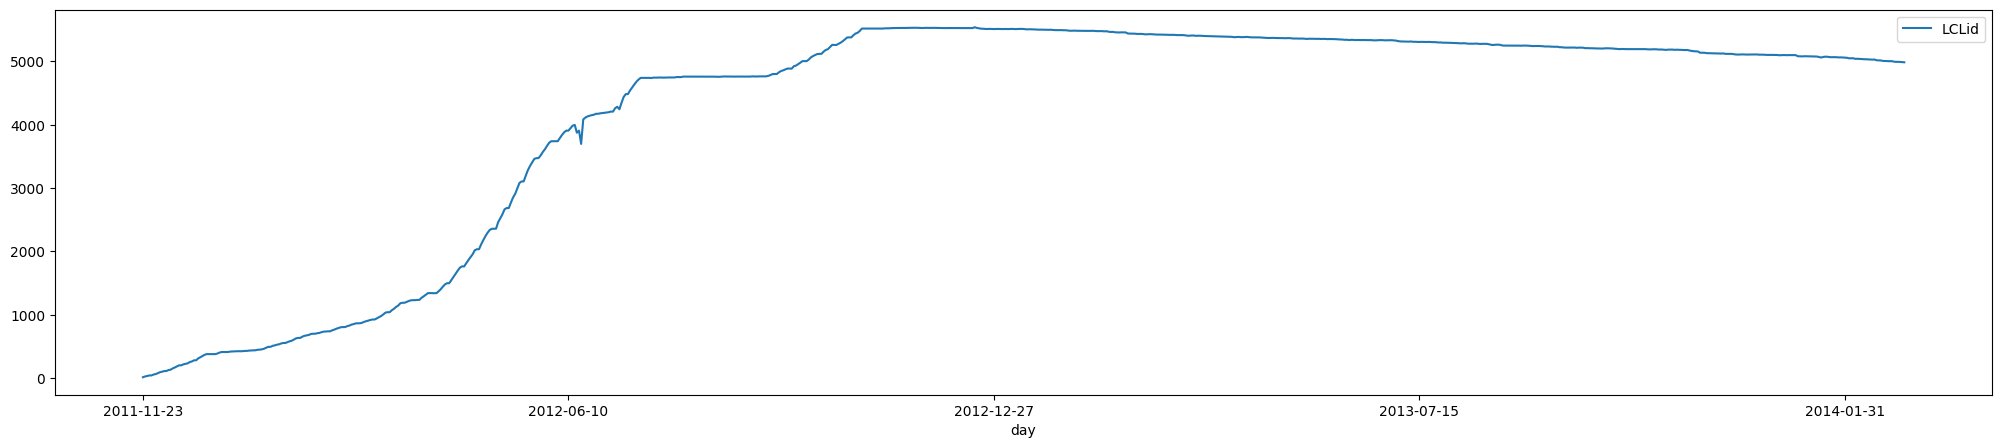

In [11]:
housecount.plot(figsize=(25,5))

**Normalization across households**
> The data collection across households are inconsistent- therefore we will be using *energy per household* as the target to predict rather than energy alone. This is an optional step as we can also predict for energy sum as whole for each household. However there are quite a lot of unique households for which we have to repeat the exercise and our ultimate goal is to predict overall consumption forecast and not at household level.  
This also means that since household level is removed, we are not looking into the ACORN details which is available at household level

In [12]:
energy = energy.groupby('day')[['energy_sum']].sum()
energy = energy.merge(housecount, on = ['day'])
energy = energy.reset_index()

In [13]:
energy.count()

day           829
energy_sum    829
LCLid         829
dtype: int64

In [14]:
energy.day = pd.to_datetime(energy.day,format='%Y-%m-%d').dt.date

In [15]:
energy['avg_energy'] =  energy['energy_sum']/energy['LCLid']
print("Starting Point of Data at Day Level",min(energy.day))
print("Ending Point of Data at Day Level",max(energy.day))

Starting Point of Data at Day Level 2011-11-23
Ending Point of Data at Day Level 2014-02-28


In [16]:
energy.describe()

,energy_sum,LCLid,avg_energy
count,829.000000,829.000000,829.000000
mean,42871.082064,4234.539204,10.358525
std,20141.685144,1789.994799,1.886255
min,90.385000,13.000000,0.208997
25%,34421.895002,4084.000000,8.565752
50%,45846.575997,5138.000000,10.372293
75%,58795.512000,5369.000000,11.832222
max,82650.492003,5541.000000,15.940238


## Weather Information
Daily level weather information is taken using darksky api in the dataset[](http://)

In [17]:
weather = read_csv_with_auto_encoding(os.path.join(drive_folder_path, 'weather_daily_darksky.csv'))
weather.head(10)

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,...,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,...,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,...,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53
2,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,...,10.33,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10
3,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,...,7.36,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25
4,8.22,2011-12-24 23:00:00,252,partly-cloudy-night,2.79,2011-12-24 07:00:00,0.37,4.46,1028.17,2011-12-24 07:00:00,...,7.93,2011-12-24 08:06:15,2011-12-24 15:00:00,2011-12-24 13:00:00,Mostly cloudy throughout the day.,2011-12-24 19:00:00,-0.51,2011-12-24 23:00:00,2011-12-24 20:00:00,0.99
5,7.97,2011-12-15 14:00:00,234,wind,2.41,2011-12-15 00:00:00,0.42,4.71,996.75,2011-12-15 00:00:00,...,7.97,2011-12-15 08:00:46,2011-12-15 14:00:00,2011-12-15 11:00:00,Partly cloudy throughout the day and breezy in...,2011-12-16 08:00:00,1.07,2011-12-15 21:00:00,2011-12-16 08:00:00,0.66
6,13.19,2011-11-19 14:00:00,117,fog,8.12,2011-11-19 23:00:00,0.26,2.37,1016.80,2011-11-19 08:00:00,...,13.19,2011-11-19 07:26:03,2011-11-19 14:00:00,2011-11-19 10:00:00,Foggy starting in the evening.,2011-11-20 08:00:00,5.98,2011-11-19 14:00:00,2011-11-20 08:00:00,0.79
7,8.32,2011-11-16 23:00:00,117,fog,5.58,2011-11-16 07:00:00,0.81,2.36,1017.40,2011-11-16 04:00:00,...,8.18,2011-11-16 07:20:57,2011-11-16 14:00:00,2011-11-16 11:00:00,Foggy starting in the evening.,2011-11-16 19:00:00,2.93,2011-11-16 23:00:00,2011-11-16 19:00:00,0.68
8,9.82,2011-12-12 23:00:00,221,wind,4.10,2011-12-12 07:00:00,0.38,5.02,1002.47,2011-12-12 08:00:00,...,8.53,2011-12-12 07:58:02,2011-12-12 19:00:00,2011-12-12 11:00:00,Partly cloudy throughout the day and breezy st...,2011-12-13 08:00:00,-0.64,2011-12-12 23:00:00,2011-12-13 08:00:00,0.56
9,9.71,2011-11-20 14:00:00,115,fog,6.62,2011-11-20 08:00:00,0.41,1.24,1018.82,2011-11-20 08:00:00,...,9.71,2011-11-20 07:27:43,2011-11-20 14:00:00,2011-11-20 10:00:00,Foggy in the morning.,2011-11-21 02:00:00,4.76,2011-11-20 15:00:00,2011-11-21 01:00:00,0.82


In [18]:
weather.describe()

,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
count,882.000000,882.000000,882.000000,881.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,881.000000,882.000000,882.000000,882.000000,882.000000,882.000000
mean,13.660113,195.702948,6.530034,0.477605,3.581803,1014.127540,12.723866,11.167143,0.781871,6.085045,12.929467,2.542565,7.709841,7.414161,13.542392,5.738039,0.500930
std,6.182744,89.340783,4.830875,0.193514,1.694007,11.073038,7.279168,2.466109,0.095348,6.031967,7.105426,1.832985,4.871004,4.888852,6.260196,6.048746,0.287022
min,-0.060000,0.000000,-7.840000,0.000000,0.200000,979.250000,-6.460000,1.480000,0.430000,-8.880000,-4.110000,0.000000,-5.640000,-5.640000,-0.810000,-8.880000,0.000000
25%,9.502500,120.500000,3.180000,0.350000,2.370000,1007.435000,7.032500,10.327500,0.720000,1.522500,7.332500,1.000000,3.990000,3.705000,9.212500,1.105000,0.260000
50%,12.625000,219.000000,6.380000,0.470000,3.440000,1014.615000,12.470000,11.970000,0.790000,5.315000,12.625000,2.000000,7.540000,7.100000,12.470000,4.885000,0.500000
75%,17.920000,255.000000,10.057500,0.600000,4.577500,1021.755000,17.910000,12.830000,0.860000,11.467500,17.920000,4.000000,11.467500,11.277500,17.910000,11.277500,0.750000
max,32.400000,359.000000,17.770000,1.000000,9.960000,1040.920000,32.420000,15.340000,0.980000,20.540000,32.420000,7.000000,20.540000,20.540000,32.400000,20.540000,0.990000


In [19]:
weather['day']=  pd.to_datetime(weather['time']) # day is given as timestamp
weather['day']=  pd.to_datetime(weather['day'],format='%Y%m%d').dt.date
# selecting numeric variables
weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase','day']]
weather = weather.dropna()

### Relationship of weather conditions with electricity consumption

In [20]:
weather_energy =  energy.merge(weather,on='day')
weather_energy.head(2)

,day,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,...,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
0,2011-11-23,90.385,13,6.952692,10.36,229,6.29,0.36,2.04,1027.12,...,8.06,0.93,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94
1,2011-11-24,213.412,25,8.536480,12.93,204,8.56,0.41,4.04,1027.22,...,10.64,0.89,7.30,12.93,1.0,9.71,8.56,12.93,7.01,0.97


 *** 1. Temperature ***
> We can see that energy and temperature have an inverse relationship-we can see the peaks in one appearing with troughs in the other. This confirms the business intuition that during low temperature, it is likely that the energy consumption through heaters etc. increases.

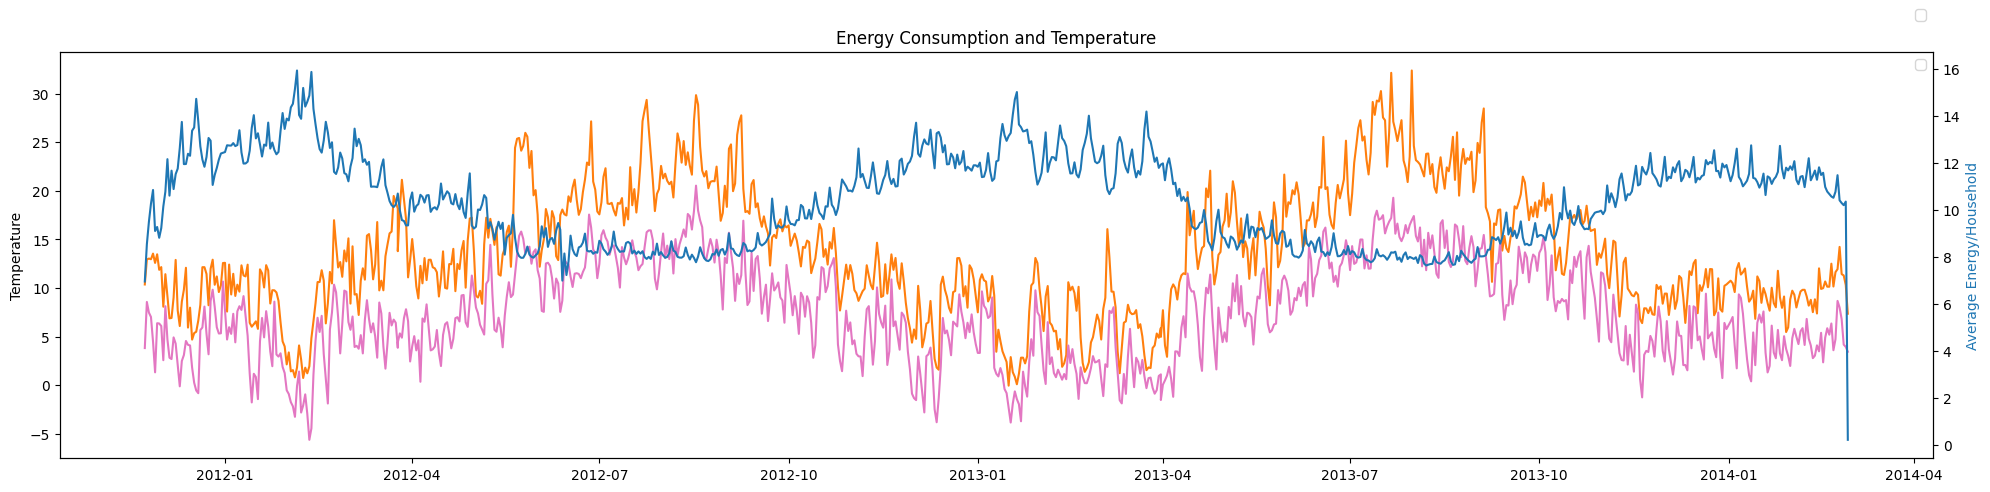

In [21]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.temperatureMax, color = 'tab:orange')
ax1.plot(weather_energy.day, weather_energy.temperatureMin, color = 'tab:pink')
ax1.set_ylabel('Temperature')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Temperature')
fig.tight_layout()
plt.show()


***2.  Humidity ***

>  Humidity and the average consumption of energy seems to have the same trend.


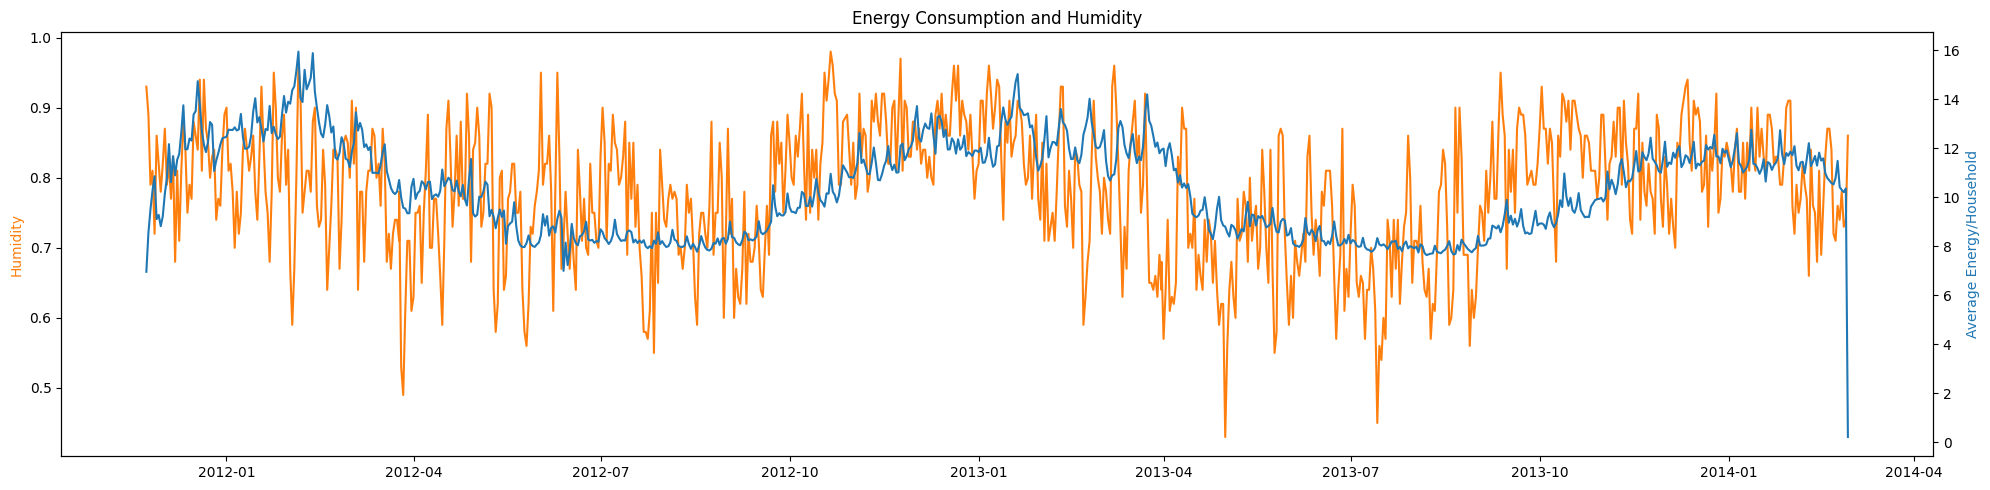

In [22]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.humidity, color = 'tab:orange')
ax1.set_ylabel('Humidity',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Humidity')
fig.tight_layout()
plt.show()

***3. Cloud Cover***
> The cloud cover value seems to be following the same pattern as the energy consumption.

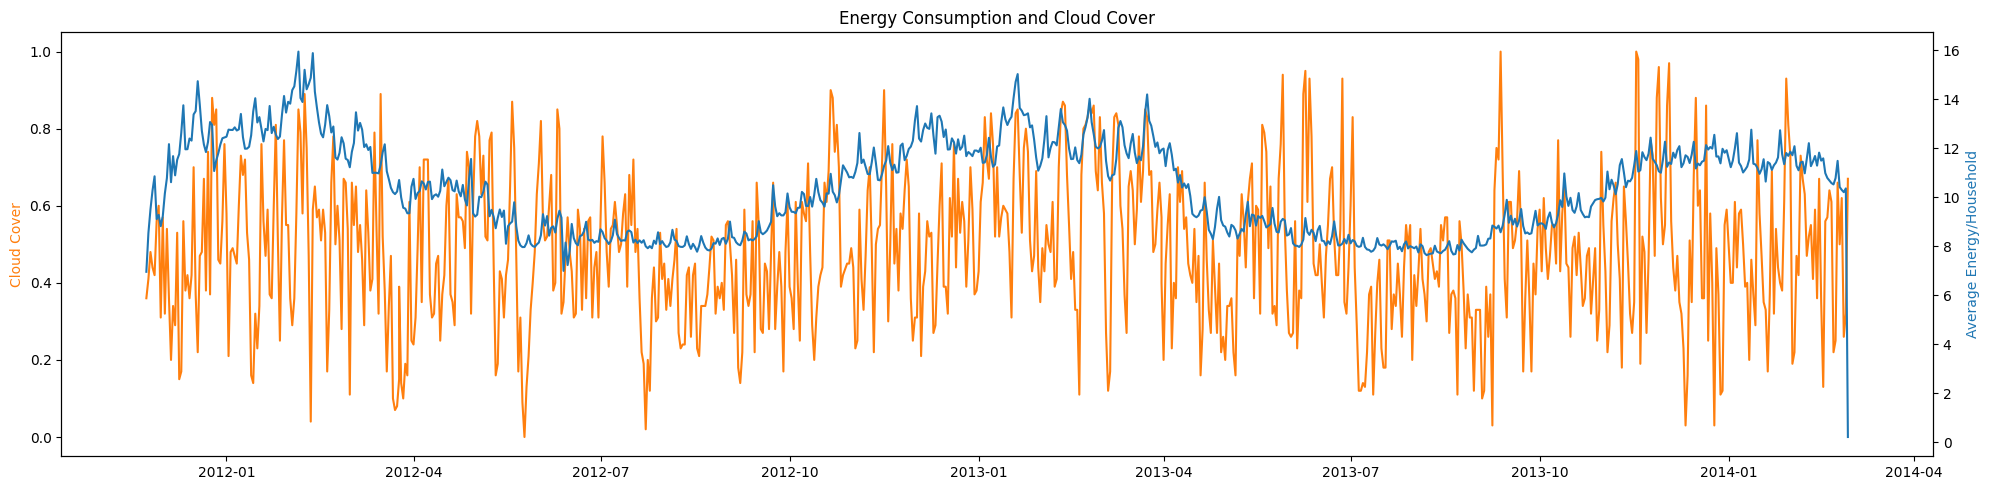

In [23]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.cloudCover, color = 'tab:orange')
ax1.set_ylabel('Cloud Cover',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Cloud Cover')
fig.tight_layout()
plt.show()

***4. Visibility***
> The visibility factor does not seem to affect energy consumption at all- since visibility is most likely an outdoors factor, it is unlikely that it's increase or decrease affects energy consumption within a household.

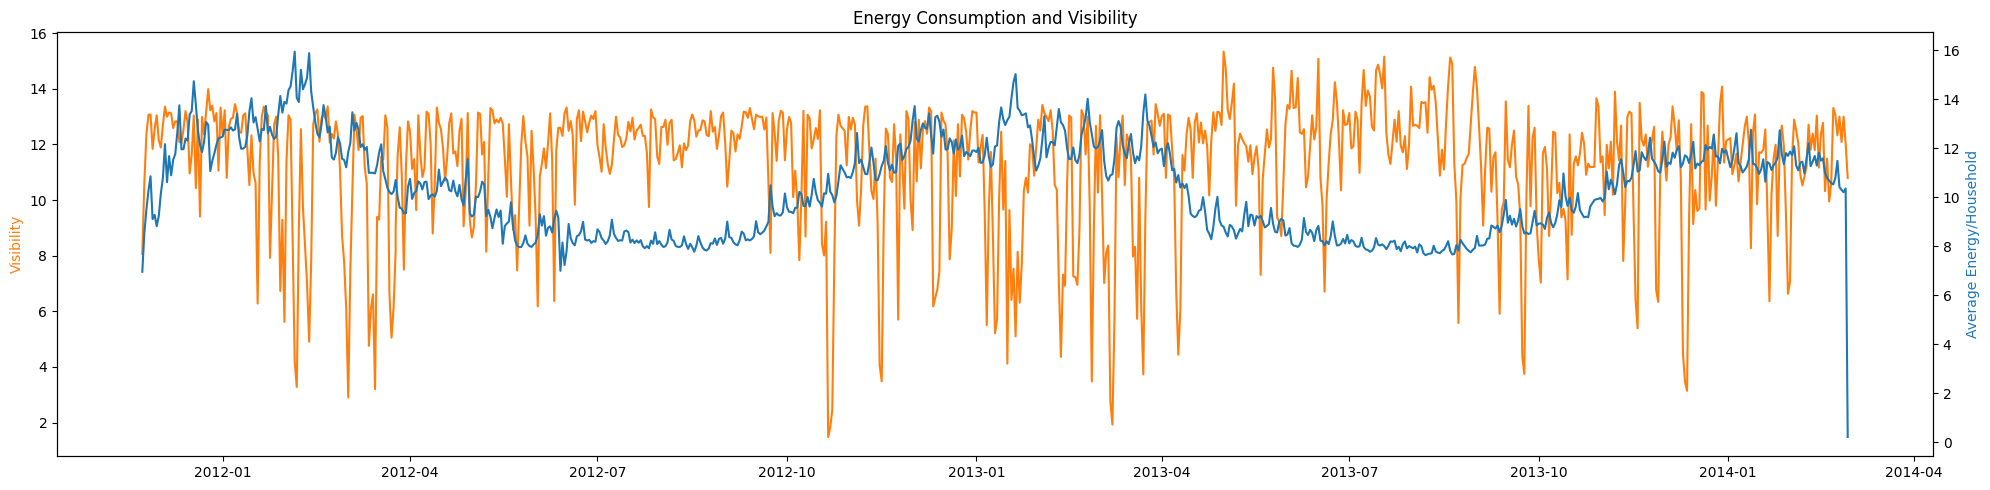

In [24]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.visibility, color = 'tab:orange')
ax1.set_ylabel('Visibility',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Visibility')
fig.tight_layout()
plt.show()

***5.  Wind Speed***
>  Like visibility, wind speed seems to be an outdoors factor which does not affect in the energy consumption as such.

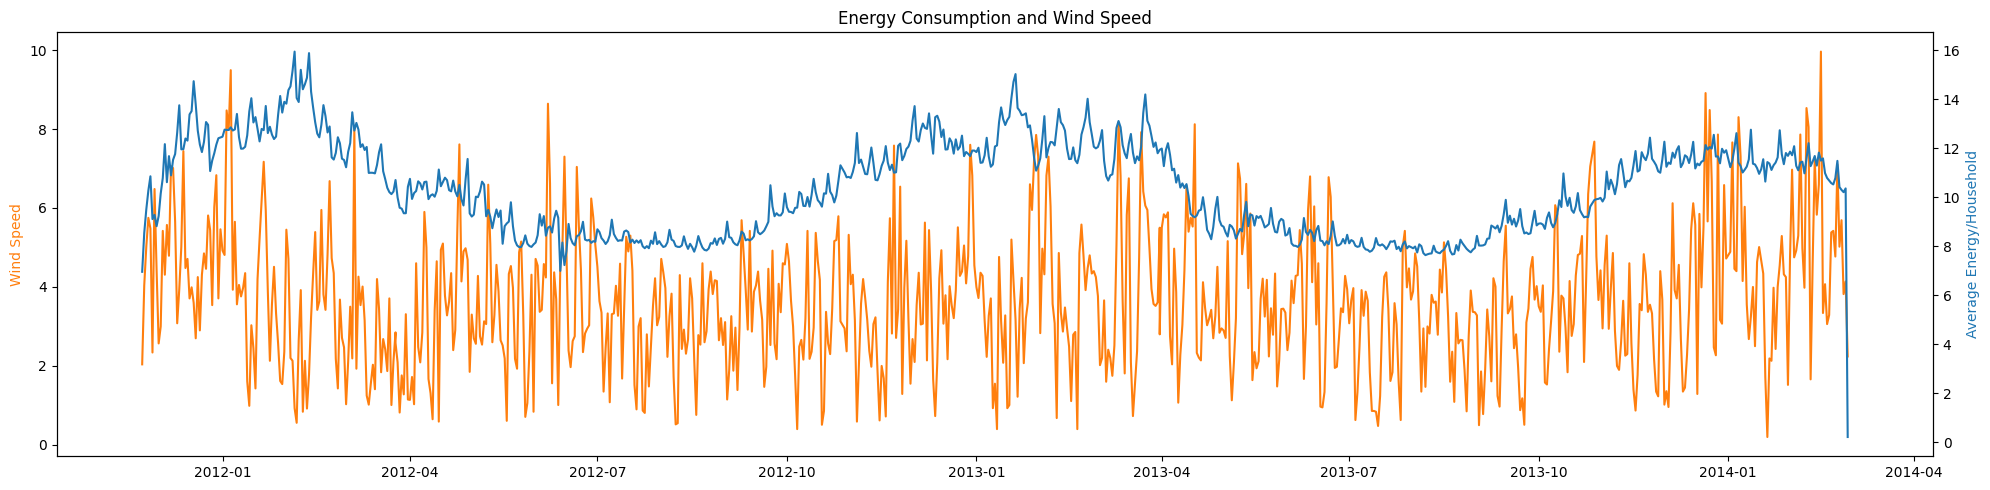

In [25]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.windSpeed, color = 'tab:orange')
ax1.set_ylabel('Wind Speed',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Wind Speed')
fig.tight_layout()
plt.show()

***6.  UV Index***
> The UV index has an inverse relationship with energy consumption- why?

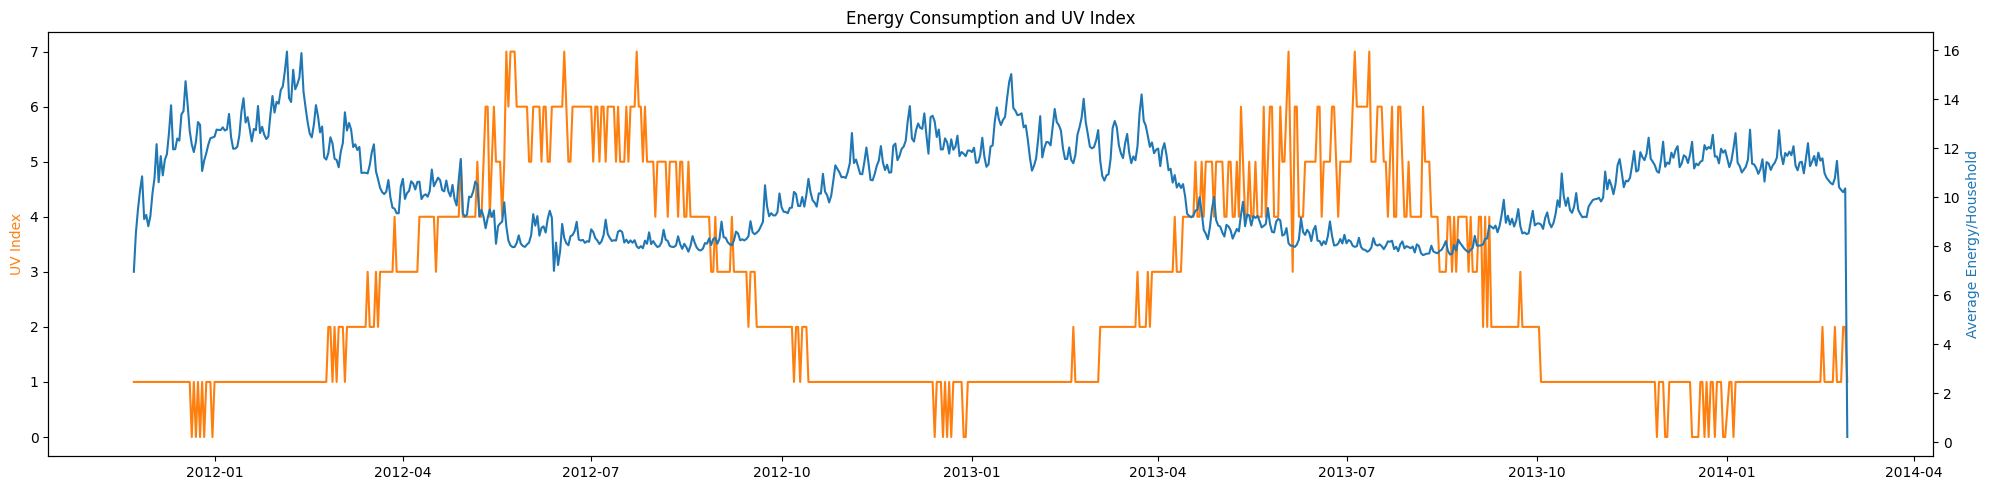

In [26]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.uvIndex, color = 'tab:orange')
ax1.set_ylabel('UV Index',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and UV Index')
fig.tight_layout()
plt.show()

***7. dewPoint***
> Dew Point- is a function of humidity and temperature display similar relation to energy consumption.

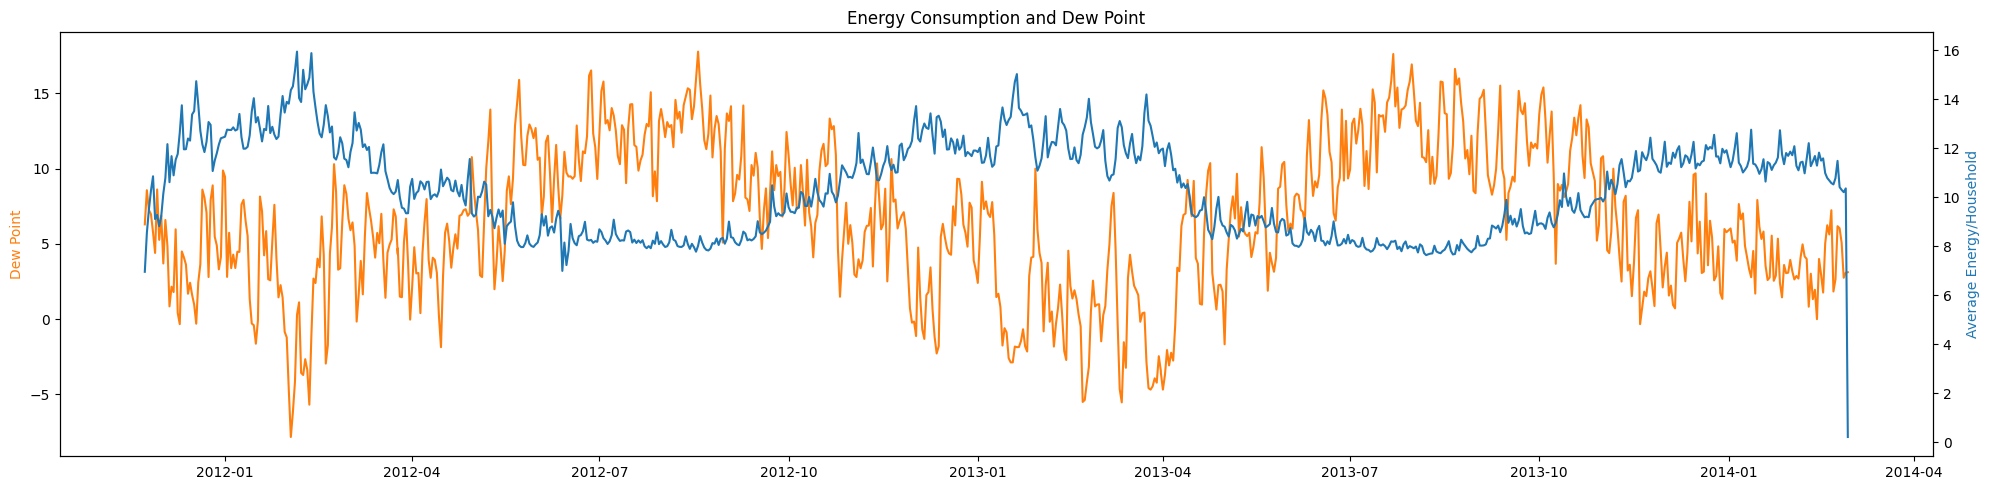

In [27]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.dewPoint, color = 'tab:orange')
ax1.set_ylabel('Dew Point',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Dew Point')
fig.tight_layout()
plt.show()

### Correlation between Weather Variables and Energy Consumption
* Energy has high positive correlation with humidity and high negative correlation with temperature.
* Multicollinearity between Dew Point, UV Index display with Temperature.
* Cloud Cover and Visibility display multicollinearity with Humidity
* Pressure and Moon Phase have minimal correlation with Energy.
* Wind Speed has low correlation with energy.


In [28]:
cor_matrix = weather_energy[['avg_energy','temperatureMax','dewPoint', 'cloudCover', 'windSpeed','pressure', 'visibility', 'humidity','uvIndex', 'moonPhase']].corr()
cor_matrix

,avg_energy,temperatureMax,dewPoint,cloudCover,windSpeed,pressure,visibility,humidity,uvIndex,moonPhase
avg_energy,1.000000,-0.843233,-0.753347,0.239685,0.148006,-0.018153,-0.243777,0.358320,-0.727422,-0.031525
temperatureMax,-0.843233,1.000000,0.865038,-0.333409,-0.153602,0.118933,0.259108,-0.404899,0.696497,0.003636
dewPoint,-0.753347,0.865038,1.000000,-0.025207,-0.092212,-0.028121,0.042633,0.055514,0.486692,-0.008239
cloudCover,0.239685,-0.333409,-0.025207,1.000000,0.170235,-0.101079,-0.330177,0.480056,-0.248695,-0.062126
windSpeed,0.148006,-0.153602,-0.092212,0.170235,1.000000,-0.344354,0.281088,-0.042391,-0.152634,-0.023273
pressure,-0.018153,0.118933,-0.028121,-0.101079,-0.344354,1.000000,-0.012508,-0.250941,0.100774,0.038462
visibility,-0.243777,0.259108,0.042633,-0.330177,0.281088,-0.012508,1.000000,-0.578130,0.240485,0.062813
humidity,0.358320,-0.404899,0.055514,0.480056,-0.042391,-0.250941,-0.578130,1.000000,-0.533919,-0.013997
uvIndex,-0.727422,0.696497,0.486692,-0.248695,-0.152634,0.100774,0.240485,-0.533919,1.000000,0.012833
moonPhase,-0.031525,0.003636,-0.008239,-0.062126,-0.023273,0.038462,0.062813,-0.013997,0.012833,1.000000


### Creating Weather Clusters


In [29]:
#scaling
scaler = MinMaxScaler()
weather_scaled = scaler.fit_transform(weather_energy[['temperatureMax','humidity','windSpeed']])

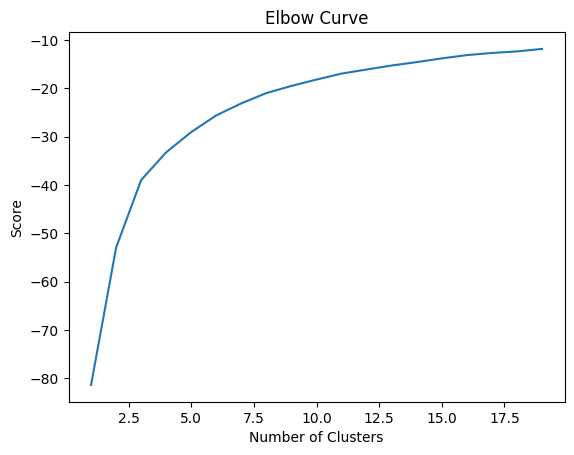

In [30]:
# optimum K
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans

score = [kmeans[i].fit(weather_scaled).score(weather_scaled) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [31]:
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
kmeans.fit(weather_scaled)
weather_energy['weather_cluster'] = kmeans.labels_

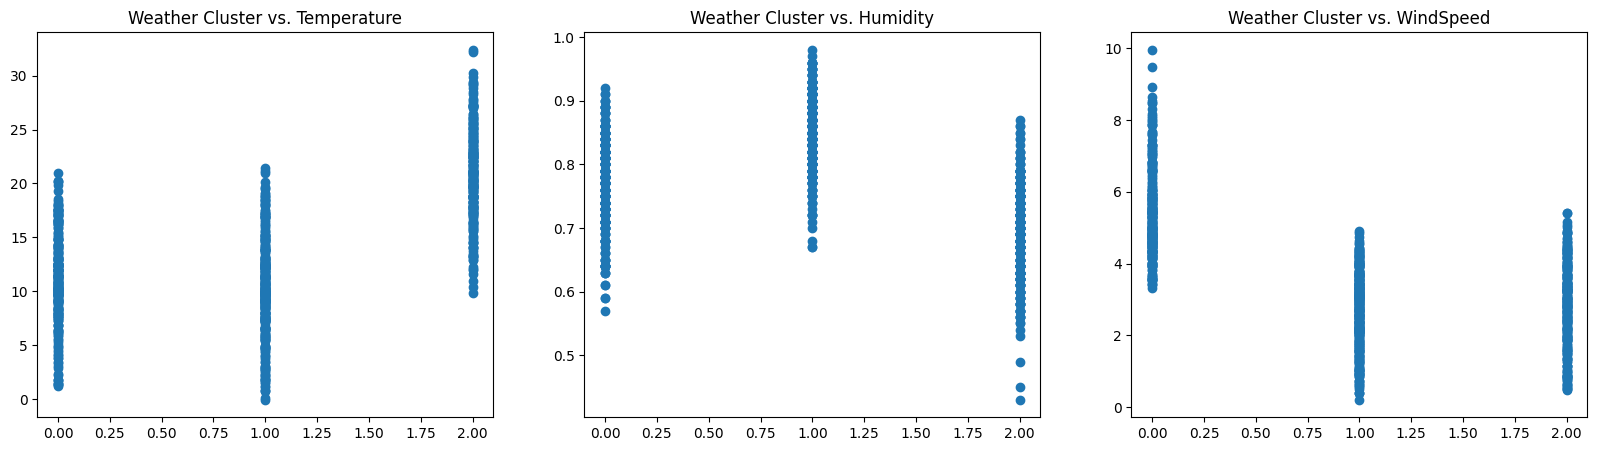

In [32]:
# Cluster Relationships with weather variables
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.scatter(weather_energy.weather_cluster,weather_energy.temperatureMax)
plt.title('Weather Cluster vs. Temperature')
plt.subplot(1, 3, 2)
plt.scatter(weather_energy.weather_cluster,weather_energy.humidity)
plt.title('Weather Cluster vs. Humidity')
plt.subplot(1, 3, 3)
plt.scatter(weather_energy.weather_cluster,weather_energy.windSpeed)
plt.title('Weather Cluster vs. WindSpeed')

plt.show()
# put this in a loop

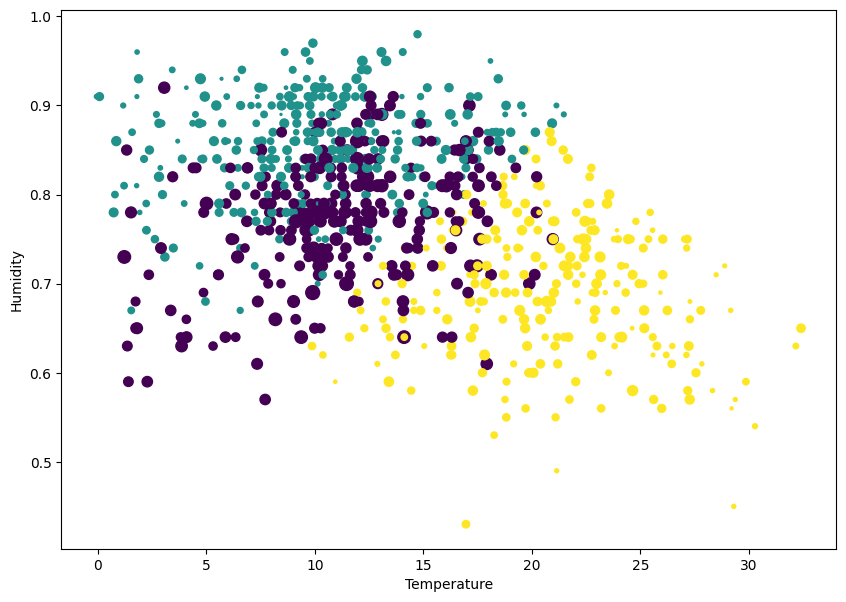

In [33]:
fig, ax1 = plt.subplots(figsize = (10,7))
ax1.scatter(weather_energy.temperatureMax,
            weather_energy.humidity,
            s = weather_energy.windSpeed*10,
            c = weather_energy.weather_cluster)
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Humidity')
plt.show()

##Customer Clusters

In [34]:
# Define function for dynamic clustering
def dynamic_clustering(data, window_size, num_clusters):
    clusters = []
    scaler = MinMaxScaler()  # Normalize data for clustering
    for i in range(len(data) - window_size + 1):
        window_data = data[i:i+window_size]  # Extract window of data
        window_scaled = scaler.fit_transform(window_data)  # Normalize window data
        kmeans = KMeans(n_clusters=num_clusters).fit(window_scaled)  # Apply K-means clustering
        clusters.append(kmeans.labels_)  # Store cluster labels
    return np.array(clusters)

In [35]:
# Define parameters for dynamic clustering
window_size = 30  # Define rolling window size (e.g., 30 days)
num_clusters = 5  # Define number of clusters

In [36]:
# Perform dynamic clustering on energy consumption data
energy_data = energy[['day', 'energy_sum', 'LCLid']]  # Select relevant columns
energy_data = energy_data.pivot(index='day', columns='LCLid', values='energy_sum')  # Pivot table for each household's energy consumption
energy_data = energy_data.fillna(0)  # Replace missing values with 0 (assuming no energy consumption)
clusters = dynamic_clustering(energy_data.values, window_size, num_clusters)

# Add cluster labels to energy data
energy_data['cluster'] = np.nan
for i, cluster in enumerate(clusters):
    energy_data.iloc[i:i+window_size, -1] = cluster

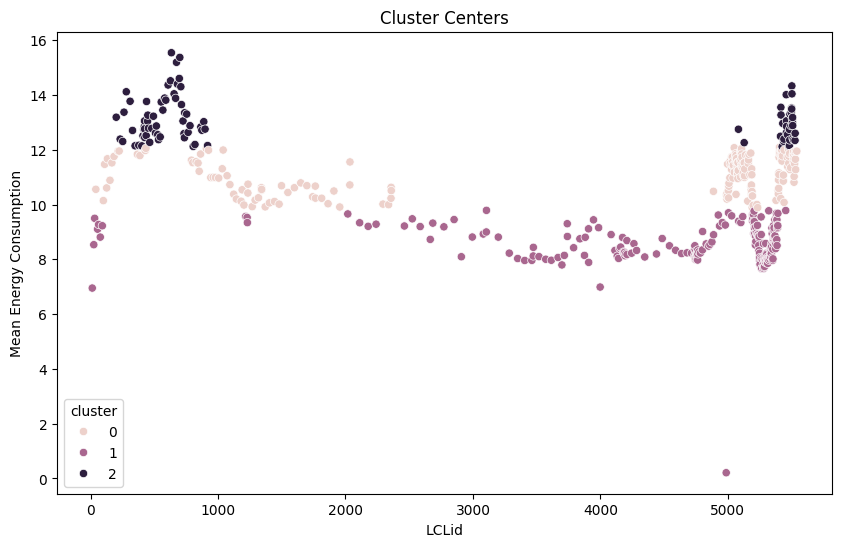

In [37]:
# Group by LCLid and calculate mean energy consumption
mean_energy = weather_energy.groupby('LCLid')['avg_energy'].mean().reset_index()

# Select features for clustering
X = mean_energy[['avg_energy']]

# Initialize and fit KMeans clustering algorithm
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

# Add cluster labels to the dataframe
mean_energy['cluster'] = kmeans.labels_

# Visualize cluster centers
plt.figure(figsize=(10, 6))
sns.scatterplot(x='LCLid', y='avg_energy', hue='cluster', data=mean_energy)
plt.title('Cluster Centers')
plt.xlabel('LCLid')
plt.ylabel('Mean Energy Consumption')
plt.show()


In [38]:
weather_energy

,day,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,...,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,weather_cluster
0,2011-11-23,90.385000,13,6.952692,10.36,229,6.29,0.36,2.04,1027.12,...,0.93,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94,1
1,2011-11-24,213.412000,25,8.536480,12.93,204,8.56,0.41,4.04,1027.22,...,0.89,7.30,12.93,1.0,9.71,8.56,12.93,7.01,0.97,1
2,2011-11-25,303.993000,32,9.499781,13.03,243,7.24,0.48,5.02,1024.47,...,0.79,4.69,13.03,1.0,7.01,7.46,12.27,4.84,0.01,0
3,2011-11-26,420.976000,41,10.267707,12.96,237,6.96,0.44,5.75,1025.80,...,0.81,11.59,12.96,1.0,11.59,7.01,12.96,4.69,0.05,0
4,2011-11-27,444.883001,41,10.850805,13.54,256,5.76,0.42,5.48,1021.11,...,0.72,1.31,13.54,1.0,1.31,4.47,13.54,2.94,0.08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,2014-02-24,51994.547004,4994,10.411403,14.23,183,6.03,0.50,5.02,1005.19,...,0.74,4.78,14.23,1.0,8.25,7.99,14.23,5.52,0.82,0
824,2014-02-25,51423.508001,4995,10.294997,11.43,202,5.06,0.62,5.69,1000.65,...,0.78,1.67,11.43,1.0,4.17,6.79,10.31,3.89,0.86,0
825,2014-02-26,50943.305995,4993,10.202945,11.29,227,2.74,0.26,3.82,1012.73,...,0.73,3.03,11.29,2.0,6.01,4.17,11.29,1.67,0.90,0
826,2014-02-27,51678.185998,4990,10.356350,10.31,224,3.08,0.32,4.14,1007.02,...,0.74,0.82,10.31,2.0,3.43,3.93,10.31,1.41,0.93,0


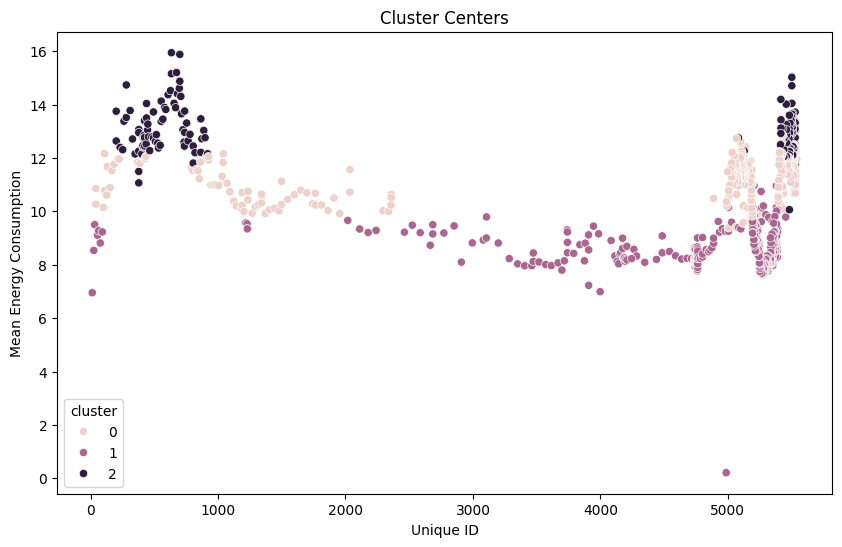

In [39]:
# Merge mean_energy DataFrame with original data on the common identifier
weather_energy_with_cluster = weather_energy.merge(mean_energy[['LCLid', 'cluster']], on='LCLid', how='left')

# Visualize cluster centers
plt.figure(figsize=(10, 6))
sns.scatterplot(x='LCLid', y='avg_energy', hue='cluster', data=weather_energy_with_cluster)
plt.title('Cluster Centers')
plt.xlabel('Unique ID')
plt.ylabel('Mean Energy Consumption')
plt.show()

The `LCLid` might not be directly used as numerical values for plotting on the x-axis. Instead, they might be encoded or transformed in a way that allows for visualization.

In [40]:
# Check for missing values in the DataFrame
missing_values = weather_energy_with_cluster.isnull().sum()

# Display columns with missing values
print("Columns with missing values:")
print(missing_values[missing_values > 0])

Columns with missing values:
Series([], dtype: int64)


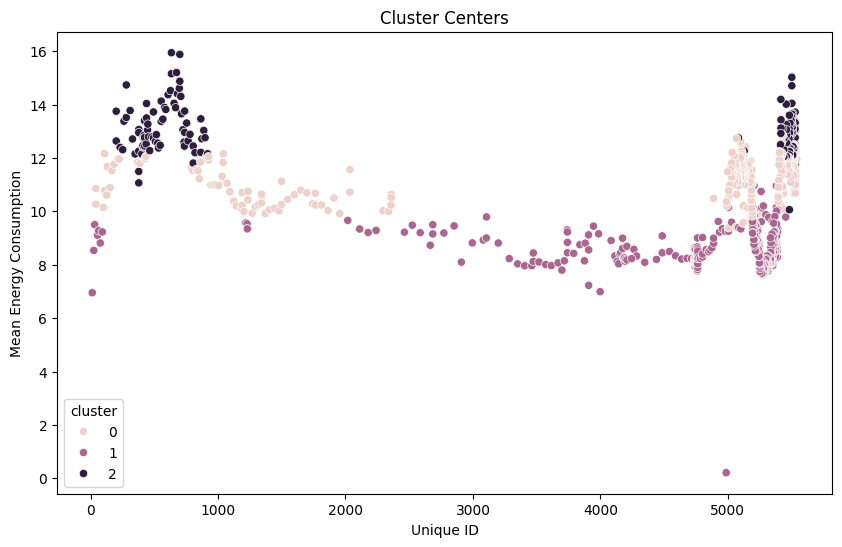

In [41]:
# Merge mean_energy DataFrame with original data on the common identifier
weather_energy_with_cluster = weather_energy.merge(mean_energy[['LCLid', 'cluster']], on='LCLid', how='left')

# Visualize cluster centers
plt.figure(figsize=(10, 6))
sns.scatterplot(x='LCLid', y='avg_energy', hue='cluster', data=weather_energy_with_cluster)
plt.title('Cluster Centers')
plt.xlabel('Unique ID')
plt.ylabel('Mean Energy Consumption')
plt.show()


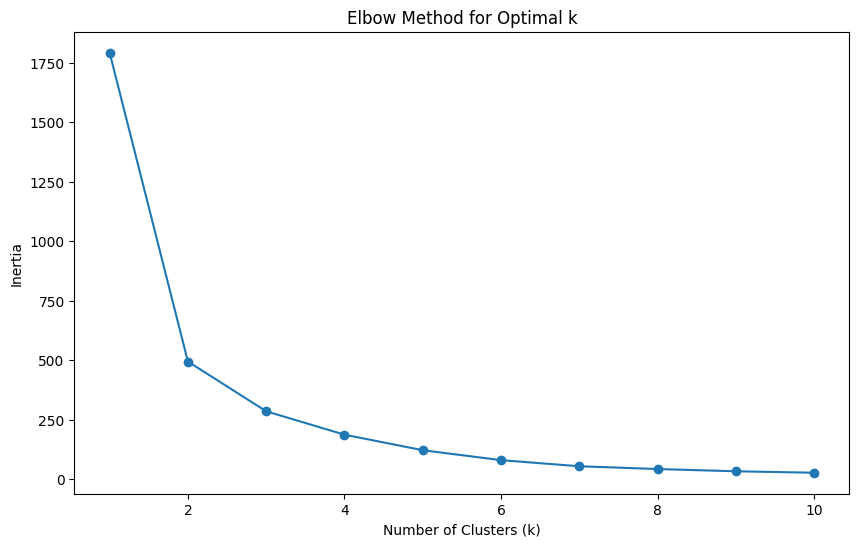

In [42]:
# Initialize an empty list to store the inertia (within-cluster sum of squares) for different values of k
inertia = []

# Iterate through different values of k
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [43]:
weather_energy_with_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828 entries, 0 to 827
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   day                      828 non-null    object 
 1   energy_sum               828 non-null    float64
 2   LCLid                    828 non-null    int64  
 3   avg_energy               828 non-null    float64
 4   temperatureMax           828 non-null    float64
 5   windBearing              828 non-null    int64  
 6   dewPoint                 828 non-null    float64
 7   cloudCover               828 non-null    float64
 8   windSpeed                828 non-null    float64
 9   pressure                 828 non-null    float64
 10  apparentTemperatureHigh  828 non-null    float64
 11  visibility               828 non-null    float64
 12  humidity                 828 non-null    float64
 13  apparentTemperatureLow   828 non-null    float64
 14  apparentTemperatureMax   8

# Can machine learning models recommend personalized energy-saving strategies for specific consumer segments?

These metrics provide an insight into how well your models are performing on the test data. Lower values of MAE and RMSE indicate better model performance.

### Bank Holidays affecting usage patterns

In [44]:
holiday = read_csv_with_auto_encoding(os.path.join(drive_folder_path, 'uk_bank_holidays.csv'))
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays'],format='%Y-%m-%d').dt.date
holiday.head(4)

,Bank holidays,Type
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)


**Creating a holiday indicator on weather data**

In [45]:
weather_energy = weather_energy_with_cluster.merge(holiday, left_on = 'day',right_on = 'Bank holidays',how = 'left')
weather_energy['holiday_ind'] = np.where(weather_energy['Bank holidays'].isna(),0,1)

In [46]:
weather_energy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828 entries, 0 to 827
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   day                      828 non-null    object 
 1   energy_sum               828 non-null    float64
 2   LCLid                    828 non-null    int64  
 3   avg_energy               828 non-null    float64
 4   temperatureMax           828 non-null    float64
 5   windBearing              828 non-null    int64  
 6   dewPoint                 828 non-null    float64
 7   cloudCover               828 non-null    float64
 8   windSpeed                828 non-null    float64
 9   pressure                 828 non-null    float64
 10  apparentTemperatureHigh  828 non-null    float64
 11  visibility               828 non-null    float64
 12  humidity                 828 non-null    float64
 13  apparentTemperatureLow   828 non-null    float64
 14  apparentTemperatureMax   8

In [47]:
# Calculate descriptive statistics for the avg_energy column
descriptive_stats = weather_energy['avg_energy'].describe()

# Print the descriptive statistics
print("Descriptive Statistics for avg_energy column:")
print(descriptive_stats)

# Calculate quartiles
quartiles = weather_energy['avg_energy'].quantile([0.25, 0.5, 0.75])

# Print quartiles
print("\nQuartiles:")
print(quartiles)

# Calculate minimum and maximum values
min_value = weather_energy['avg_energy'].min()
max_value = weather_energy['avg_energy'].max()

# Print minimum and maximum values
print("\nMinimum value:", min_value)
print("Maximum value:", max_value)

Descriptive Statistics for avg_energy column:
count    828.000000
mean      10.356658
std        1.886070
min        0.208997
25%        8.565667
50%       10.376297
75%       11.820741
max       15.940238
Name: avg_energy, dtype: float64

Quartiles:
0.25     8.565667
0.50    10.376297
0.75    11.820741
Name: avg_energy, dtype: float64

Minimum value: 0.20899659111690394
Maximum value: 15.940238171924292


In [48]:
# Define the features to be used in training
features = ['weather_cluster', 'holiday_ind']

# Define lists to store evaluation metrics
mae_scores = []
rmse_scores = []

def generate_recommendations(cluster_label, predicted_energy_consumption):
    recommendations = []

    # Define thresholds based on quartiles (Q1, Q2, Q3)
    thresholds = {
        0: 8.565667,  # 25th percentile (Q1)
        1: 10.376297, # 50th percentile (Q2, median)
        2: 11.820741  # 75th percentile (Q3)
    }

    # Example recommendation logic
    for energy_consumption in predicted_energy_consumption:
        if energy_consumption > thresholds[cluster_label]:
            if cluster_label == 0:
                recommendations.append("Consider upgrading to energy-efficient appliances.")
            elif cluster_label == 1:
                recommendations.append("Adjust thermostat settings to conserve energy during peak hours.")
            elif cluster_label == 2:
                recommendations.append("Investigate renewable energy options such as solar panels.")
        else:
            if cluster_label == 0:
                recommendations.append("Ensure proper insulation to minimize heat loss.")
                recommendations.append("Use curtains or blinds to regulate indoor temperature.")
            elif cluster_label == 1:
                recommendations.append("Install a programmable thermostat for better temperature control.")
                recommendations.append("Replace old HVAC filters for improved efficiency.")
            elif cluster_label == 2:
                recommendations.append("Turn off lights and appliances when not in use to save energy.")

    return recommendations

# Iterate over each cluster
for cluster_label in range(3):  # Assuming you have 3 clusters
    # Filter data for the current cluster
    cluster_data = weather_energy[weather_energy['cluster'] == cluster_label]

    # Split the data into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(cluster_data[features], cluster_data['avg_energy'], test_size=0.2, random_state=42)

    # Initialize a model (you can choose any model here)
    # For example, using Linear Regression
    model = LinearRegression()
    # Or using Decision Tree Regression
    # model = DecisionTreeRegressor()
    # Or using Random Forest Regression
    # model = RandomForestRegressor()

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions using the trained model
    y_pred = model.predict(X_test)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_scores.append(rmse)

    # Generate personalized energy-saving recommendations
    recommendations = generate_recommendations(cluster_label, y_pred)

    # Print evaluation metrics and recommendations for the current cluster
    print(f"Cluster {cluster_label}:")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print("Recommendations:")
    for recommendation in recommendations:
        print(recommendation)
    print("-" * 30)

# Overall evaluation metrics (average or total)
print("Overall Evaluation Metrics:")
print(f"Average MAE: {sum(mae_scores) / len(mae_scores)}")
print(f"Average RMSE: {sum(rmse_scores) / len(rmse_scores)}")


Cluster 0:
MAE: 0.5685380205642023
RMSE: 0.71697928823734
Recommendations:
Consider upgrading to energy-efficient appliances.
Consider upgrading to energy-efficient appliances.
Consider upgrading to energy-efficient appliances.
Consider upgrading to energy-efficient appliances.
Consider upgrading to energy-efficient appliances.
Consider upgrading to energy-efficient appliances.
Consider upgrading to energy-efficient appliances.
Consider upgrading to energy-efficient appliances.
Consider upgrading to energy-efficient appliances.
Consider upgrading to energy-efficient appliances.
Consider upgrading to energy-efficient appliances.
Consider upgrading to energy-efficient appliances.
Consider upgrading to energy-efficient appliances.
Consider upgrading to energy-efficient appliances.
Consider upgrading to energy-efficient appliances.
Consider upgrading to energy-efficient appliances.
Consider upgrading to energy-efficient appliances.
Consider upgrading to energy-efficient appliances.
Conside

In [49]:
weather_energy_new=weather_energy

### ARIMAX

In [50]:
weather_energy_new['Year'] = pd.DatetimeIndex(weather_energy_new['day']).year
weather_energy_new['Month'] = pd.DatetimeIndex(weather_energy_new['day']).month
weather_energy_new.set_index(['day'],inplace=True)

** Subset for required columns and 70-30 train-test split**

In [51]:
model_data = weather_energy_new
 #[['avg_energy','weather_cluster','holiday_ind', 'cluster']]

# Define the percentage split
train_percentage = 0.7  # 70% of the data for training, 30% for testing

# Calculate the index to split the data
split_index = int(len(model_data) * train_percentage)

# Split the data into training and test sets
train = model_data.iloc[:split_index]
test = model_data.iloc[split_index:]

<Axes: xlabel='day'>

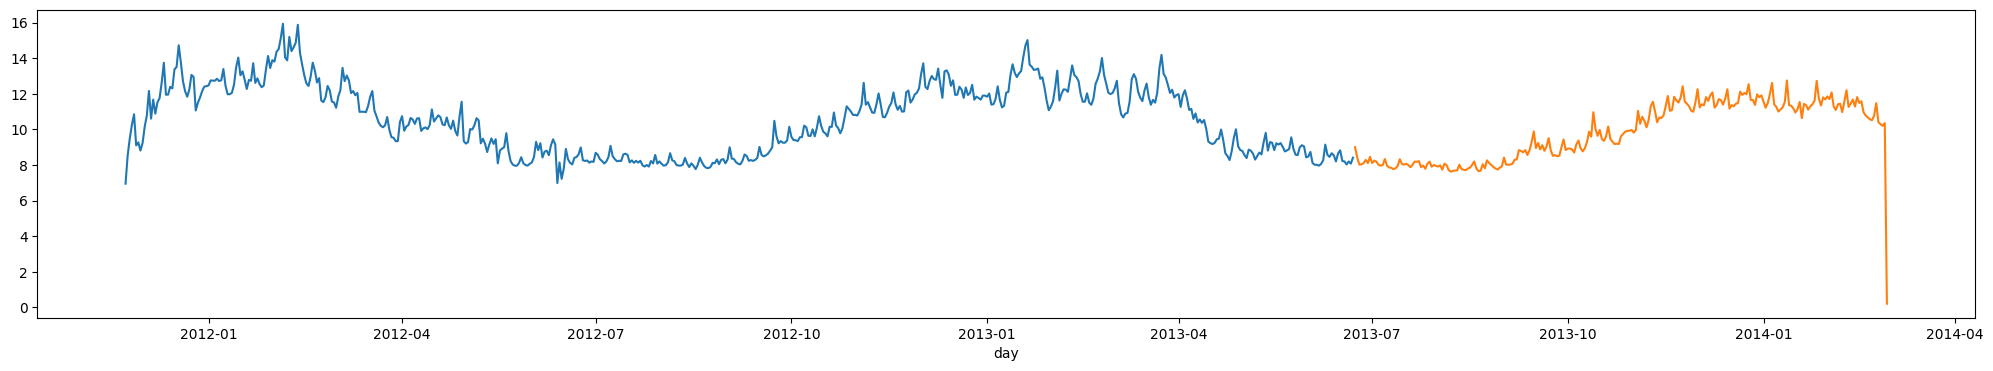

In [52]:
train['avg_energy'].plot(figsize=(25,4))
test['avg_energy'].plot(figsize=(25,4))


In [53]:
test.head(5)

,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,...,temperatureHigh,apparentTemperatureMin,moonPhase,weather_cluster,cluster,Bank holidays,Type,holiday_ind,Year,Month
day,,,,,,,,,,,,,,,,,,,,,
2013-06-23,48059.872002,5335,9.008411,16.10,290,7.04,0.52,4.16,1021.79,16.10,...,16.10,10.62,0.54,2,1,NaN,NaN,0,2013,6
2013-06-24,44903.111000,5333,8.419860,18.76,319,6.54,0.42,1.95,1028.61,18.76,...,18.76,11.26,0.58,2,1,NaN,NaN,0,2013,6
2013-06-25,42825.055997,5335,8.027190,20.61,295,8.75,0.42,1.98,1029.89,20.61,...,20.61,10.14,0.61,2,1,NaN,NaN,0,2013,6
2013-06-26,42881.584001,5336,8.036279,19.23,298,9.39,0.54,2.69,1026.49,19.23,...,19.23,12.20,0.65,2,1,NaN,NaN,0,2013,6
2013-06-27,43255.820001,5338,8.103376,20.16,277,13.92,0.93,3.46,1019.73,20.25,...,20.16,12.56,0.69,1,1,NaN,NaN,0,2013,6


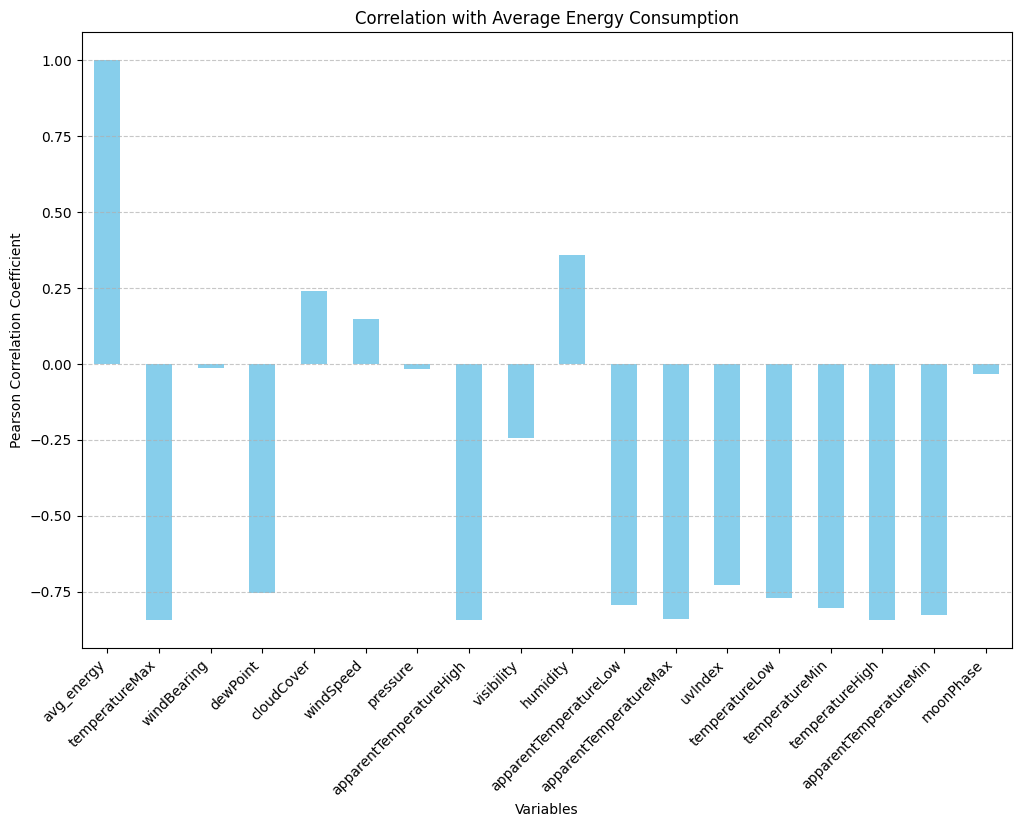

In [216]:
# Drop the "lclid" variable
weather_energy_without_lclid = weather_energy_new.drop(columns=['LCLid', 'Year', 'Month', 'weather_cluster', 'cluster', 'holiday_ind', 'energy_sum'])

# Compute the correlation coefficients with avg_energy
correlation_with_avg_energy = weather_energy_without_lclid.corrwith(weather_energy_new['avg_energy'])

# Visualize the correlation coefficients
plt.figure(figsize=(12, 8))
correlation_with_avg_energy.plot(kind='bar', color='skyblue')
plt.title('Correlation with Average Energy Consumption')
plt.xlabel('Variables')
plt.ylabel('Pearson Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [213]:
# Define a function to compute point-biserial correlation
def point_biserial_corr(x, y):
    # Convert categorical variable y to binary
    y_binary = y.astype('category').cat.codes
    return scipy.stats.pointbiserialr(x, y_binary)

# Compute point-biserial correlation between avg_energy and each categorical variable
corr_avg_energy_weather_cluster, _ = point_biserial_corr(weather_energy_without_lclid['avg_energy'], weather_energy_without_lclid['weather_cluster'])
corr_avg_energy_cluster, _ = point_biserial_corr(weather_energy_without_lclid['avg_energy'], weather_energy_without_lclid['cluster'])
corr_avg_energy_holiday_ind, _ = point_biserial_corr(weather_energy_without_lclid['avg_energy'], weather_energy_without_lclid['holiday_ind'])

print("Point-Biserial Correlation between avg_energy and weather_cluster:", corr_avg_energy_weather_cluster)
print("Point-Biserial Correlation between avg_energy and cluster:", corr_avg_energy_cluster)
print("Point-Biserial Correlation between avg_energy and holiday_ind:", corr_avg_energy_holiday_ind)


Point-Biserial Correlation between avg_energy and weather_cluster: -0.5191270547754976
Point-Biserial Correlation between avg_energy and cluster: 0.093902461620711
Point-Biserial Correlation between avg_energy and holiday_ind: 0.004328333808934793


**ACF PACF **

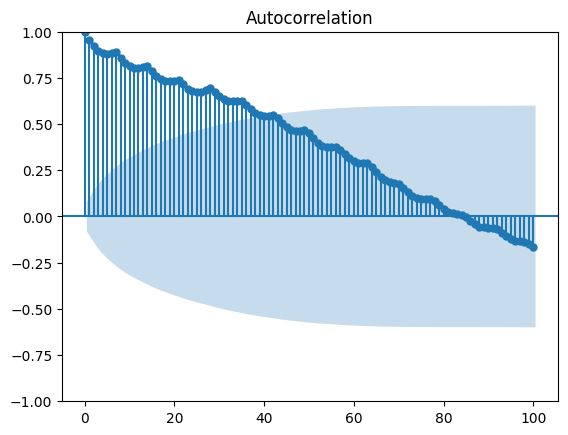

In [55]:
plot_acf(train.avg_energy,lags=100)
plt.show()

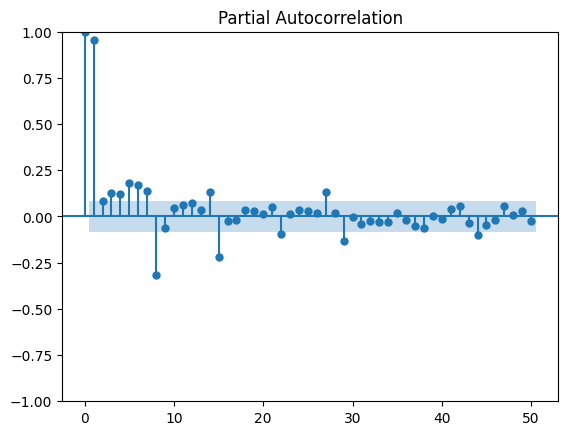

In [56]:
plot_pacf(train.avg_energy,lags=50)
plt.show()

Autocorrelation plot shows gradual decay while Partial AutoCorrelation shows that there is a sharp drop after 1st lag. This means that most of the higher-order autocorrelations are effectively explained by the k = 1 lag. Therefore, the series displays AR 'signature'

**Dickey Fuller's Test**
> p is greater than 0.05 therefore the data is not stationary. After differencing, p < 0.05.

In [57]:
t = sm.tsa.adfuller(train.avg_energy, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                  -1.558855
p-value                          0.504222
#Lags Used                      14.000000
Number of Observations Used    564.000000
dtype: float64

In [58]:
# function for differencing
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff

In [59]:
t  = sm.tsa.adfuller(difference(train.avg_energy,1), autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                -6.845031e+00
p-value                        1.751655e-09
#Lags Used                     1.300000e+01
Number of Observations Used    5.640000e+02
dtype: float64

**Seasonal Decomposition**
> The seasonal component is quite low while the trend is quite strong with obvious dips in electricity consumption during summers i.e. April to September. This may be attributed to longer days during summer.

In [60]:
s = sm.tsa.seasonal_decompose(train.avg_energy, period=12)

<Axes: xlabel='day'>

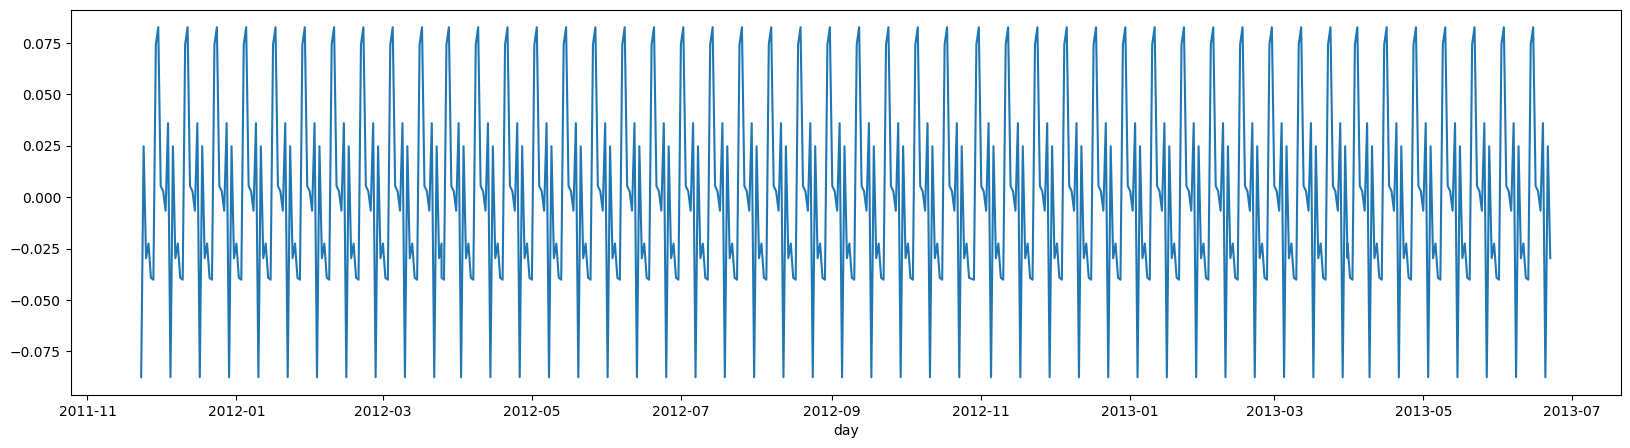

In [61]:
s.seasonal.plot(figsize=(20,5))

<Axes: xlabel='day'>

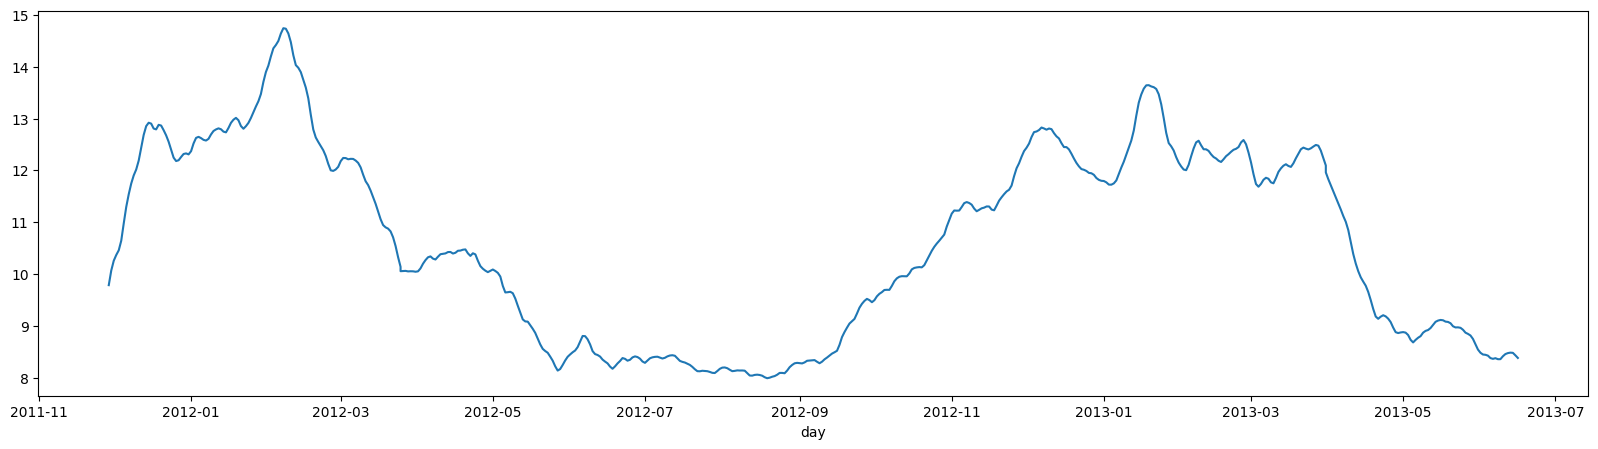

In [62]:
s.trend.plot(figsize=(20,5))

<Axes: xlabel='day'>

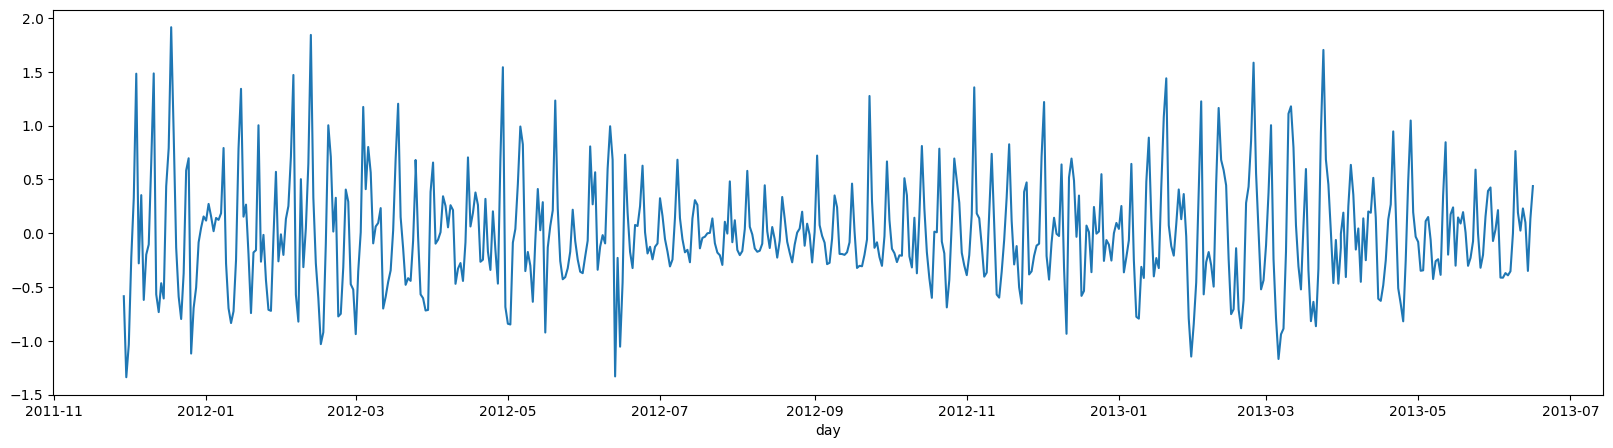

In [63]:
s.resid.plot(figsize=(20,5))

In [64]:
train

,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,...,temperatureHigh,apparentTemperatureMin,moonPhase,weather_cluster,cluster,Bank holidays,Type,holiday_ind,Year,Month
day,,,,,,,,,,,,,,,,,,,,,
2011-11-23,90.385000,13,6.952692,10.36,229,6.29,0.36,2.04,1027.12,10.36,...,10.36,2.18,0.94,1,1,NaN,NaN,0,2011,11
2011-11-24,213.412000,25,8.536480,12.93,204,8.56,0.41,4.04,1027.22,12.93,...,12.93,7.01,0.97,1,1,NaN,NaN,0,2011,11
2011-11-25,303.993000,32,9.499781,13.03,243,7.24,0.48,5.02,1024.47,12.27,...,12.27,4.84,0.01,0,1,NaN,NaN,0,2011,11
2011-11-26,420.976000,41,10.267707,12.96,237,6.96,0.44,5.75,1025.80,12.96,...,12.96,4.69,0.05,0,0,NaN,NaN,0,2011,11
2011-11-27,444.883001,41,10.850805,13.54,256,5.76,0.42,5.48,1021.11,13.54,...,13.54,2.94,0.08,0,0,NaN,NaN,0,2011,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-06-18,43804.633996,5338,8.206188,25.56,31,15.19,0.31,0.95,1014.65,25.56,...,25.56,15.83,0.35,2,1,NaN,NaN,0,2013,6
2013-06-19,42883.310002,5339,8.032087,20.19,102,14.68,0.47,1.34,1012.05,20.20,...,20.19,16.22,0.39,2,1,NaN,NaN,0,2013,6
2013-06-20,43769.770000,5338,8.199657,20.38,231,13.56,0.55,3.59,1010.05,20.38,...,20.38,14.11,0.42,2,1,NaN,NaN,0,2013,6


In [67]:
# Convert endog and exog to numpy arrays
endog = train['avg_energy'].values
# Select the columns you want to include in exog
exog_columns = ['energy_sum', 'temperatureMax', 'windBearing', 'dewPoint', 'cloudCover',
                'windSpeed', 'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
                'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex', 'temperatureLow',
                'temperatureMin', 'temperatureHigh', 'apparentTemperatureMin', 'moonPhase',
                'holiday_ind', 'Year', 'Month']

# Create exog DataFrame with selected columns
exog = train[exog_columns]

# Add constant to exog
exog = sm.add_constant(exog)

# Convert exog to numpy array
exog_values = exog.values

# Create SARIMAX model
mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog_values, order=(7,1,1), seasonal_order=(1,1,0,12))
model_fit = mod.fit()
model_fit.summary()


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  579
Model:             SARIMAX(7, 1, 1)x(1, 1, [], 12)   Log Likelihood                -174.731
Date:                             Sat, 30 Mar 2024   AIC                            413.463
Time:                                     04:05:20   BIC                            552.298
Sample:                                          0   HQIC                           467.649
                                             - 579                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.524e-17   2.72e-07   -1.3e-10      1.000   -5.33e-07    5.33e-07
x1             0.0002   1.25e-05     15.392      0.000       0.000       0.000
x2            -0.0861      0.045     -1.922      0.055      -0.174       0.002
x3             0.0001      0.000      0.538      0.591      -0.000       0.000
x4            -0.0087      0.029     -0.302      0.763      -0.065       0.048
x5             0.1819      0.127      1.434      0.152      -0.067       0.431
x6            -0.0053      0.012     -0.439      0.661      -0.029       0.018
x7            -0.0050      0.003     -1.904      0.057      -0.010       0.000
x8             0.0006      0.024      0.023      0.982      -0.047       0.048
x9             0.0123      0.011      1.123      0.261      -0.009       0.034
x10            0.3172      0.688      0.461      0.645      -1.032       1.667
x11            0.0227      0.011      2.024      0.043       0.001       0.045
x12           -0.0121      0.022     -0.553      0.580      -0.055       0.031
x13            0.0185      0.034      0.549      0.583      -0.048       0.085
x14           -0.0265      0.013     -1.970      0.049      -0.053      -0.000
x15           -0.0284      0.021     -1.349      0.177      -0.070       0.013
x16            0.0965      0.048      2.024      0.043       0.003       0.190
x17            0.0075      0.016      0.483      0.629      -0.023       0.038
x18           -0.0281      0.074     -0.382      0.702      -0.172       0.116
x19            0.0067      0.076      0.089      0.929      -0.143       0.156
x20           -0.0369      1.141     -0.032      0.974      -2.272       2.198
x21           -0.0183      0.100     -0.183      0.855      -0.215       0.178
ar.L1         -0.0395      0.095     -0.417      0.677      -0.225       0.146
ar.L2         -0.2326      0.031     -7.570      0.000      -0.293      -0.172
ar.L3         -0.0652      0.037     -1.757      0.079      -0.138       0.008
ar.L4         -0.1207      0.036     -3.390      0.001      -0.190      -0.051
ar.L5         -0.2009      0.035     -5.689      0.000      -0.270      -0.132
ar.L6         -0.0446      0.044     -1.010      0.312      -0.131       0.042
ar.L7          0.3662      0.030     12.348      0.000       0.308       0.424
ma.L1         -0.0652      0.115     -0.566      0.571      -0.291       0.160
ar.S.L12      -0.4547      0.038    -12.010      0.000      -0.529      -0.381
sigma2         0.1211      0.007     16.891      0.000       0.107       0.135
===================================================================================
Ljung-Box (L1) (Q):                   2.89   Jarque-Bera (JB):               857.46
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                            -0.20
Prob(H) (two-sided):   

**Model Fit**

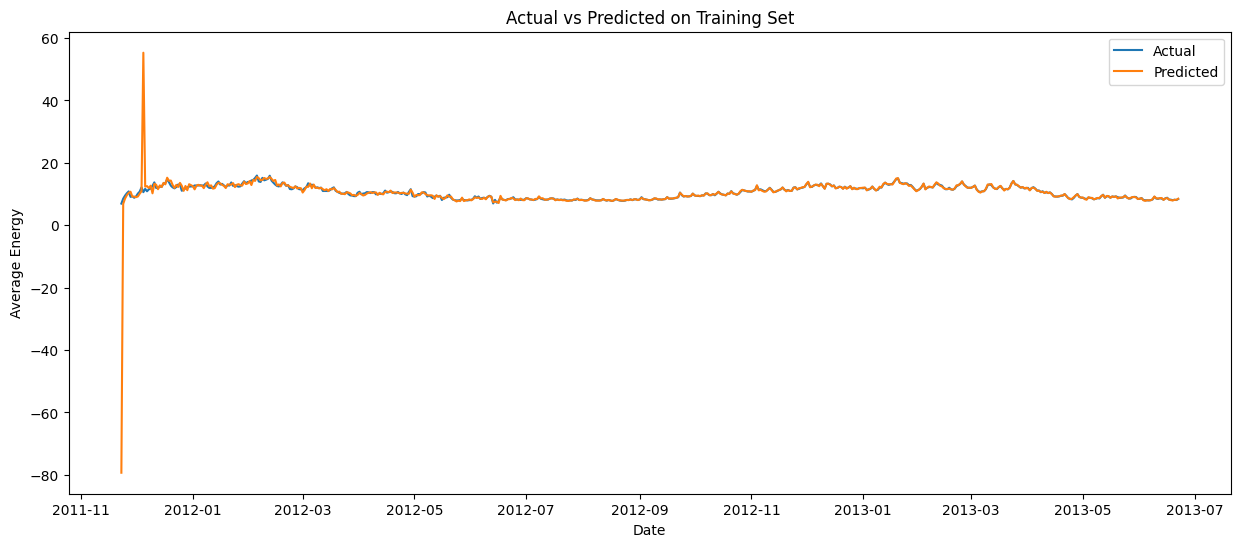

In [68]:
# Get the fitted values
fitted_values = model_fit.fittedvalues

# Plot actual vs fitted values
plt.figure(figsize=(15, 6))
plt.plot(train.index, endog, label='Actual')
plt.plot(train.index, fitted_values, label='Predicted')
plt.title('Actual vs Predicted on Training Set')
plt.xlabel('Date')
plt.ylabel('Average Energy')
plt.legend()
plt.show()

In [70]:
import plotly.graph_objs as go
import plotly.io as pio

# Assuming you have fitted an ARIMAX model named `model_fit`
# Get the fitted values
fitted_values = model_fit.fittedvalues

# Create traces for actual and fitted values
trace_actual = go.Scatter(x=train.index, y=endog, mode='lines', name='Actual')
trace_predicted = go.Scatter(x=train.index, y=fitted_values, mode='lines', name='Predicted')

# Create layout
layout = go.Layout(title='Actual vs Predicted on Training Set',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Average Energy'))

# Create figure
fig = go.Figure(data=[trace_actual, trace_predicted], layout=layout)

# Plot using Plotly
pio.show(fig)

**Prediction**

In [72]:
# Select the columns you want to include in exog for the test set
exog_columns_test = ['energy_sum', 'temperatureMax', 'windBearing', 'dewPoint', 'cloudCover',
                'windSpeed', 'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
                'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex', 'temperatureLow',
                'temperatureMin', 'temperatureHigh', 'apparentTemperatureMin', 'moonPhase',
                'holiday_ind', 'Year', 'Month']

# Create exog DataFrame with selected columns for the test set
exog_test = test[exog_columns_test]

# Add constant to exog for the test set
exog_test = sm.add_constant(exog_test)

# Predict on the test set
predict_test = model_fit.predict(start=len(train), end=len(train)+len(test)-1, exog=exog_test)

# Add predicted values to the test DataFrame
test['predicted'] = predict_test

# Display the last 5 rows of the test DataFrame with predicted values
test.tail(5)



,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,...,apparentTemperatureMin,moonPhase,weather_cluster,cluster,Bank holidays,Type,holiday_ind,Year,Month,predicted
day,,,,,,,,,,,,,,,,,,,,,
2014-02-24,51994.547004,4994,10.411403,14.23,183,6.03,0.50,5.02,1005.19,14.23,...,5.52,0.82,0,0,NaN,NaN,0,2014,2,11.994187
2014-02-25,51423.508001,4995,10.294997,11.43,202,5.06,0.62,5.69,1000.65,10.31,...,3.89,0.86,0,0,NaN,NaN,0,2014,2,11.895878
2014-02-26,50943.305995,4993,10.202945,11.29,227,2.74,0.26,3.82,1012.73,11.29,...,1.67,0.90,0,0,NaN,NaN,0,2014,2,11.913644
2014-02-27,51678.185998,4990,10.356350,10.31,224,3.08,0.32,4.14,1007.02,10.31,...,1.41,0.93,0,0,NaN,NaN,0,2014,2,12.182796
2014-02-28,1042.266000,4987,0.208997,7.35,61,3.11,0.67,2.24,998.92,4.51,...,0.82,0.97,1,1,NaN,NaN,0,2014,2,2.575011


In [73]:
test['residual'] = abs(test['avg_energy']-test['predicted'])
MAE = test['residual'].sum()/len(test)
MAPE = (abs(test['residual'])/test['avg_energy']).sum()*100/len(test)
print("MAE:", MAE)
print("MAPE:", MAPE)

MAE: 0.8329787338897101
MAPE: 12.286828788276969


In [74]:
# Calculate MAE and MAPE for training set
train_residual = abs(train['avg_energy'] - model_fit.fittedvalues)
train_MAE = train_residual.sum() / len(train)
train_MAPE = (train_residual / train['avg_energy']).sum() * 100 / len(train)
print("Training Set:")
print("MAE:", train_MAE)
print("MAPE:", train_MAPE)

# Calculate MAE and MAPE for test set
test_residual = abs(test['avg_energy'] - test['predicted'])
test_MAE = test_residual.sum() / len(test)
test_MAPE = (test_residual / test['avg_energy']).sum() * 100 / len(test)
print("\nTest Set:")
print("MAE:", test_MAE)
print("MAPE:", test_MAPE)


Training Set:
MAE: 0.4442472167298316
MAPE: 4.8733097665955105

Test Set:
MAE: 0.8329787338897101
MAPE: 12.286828788276969


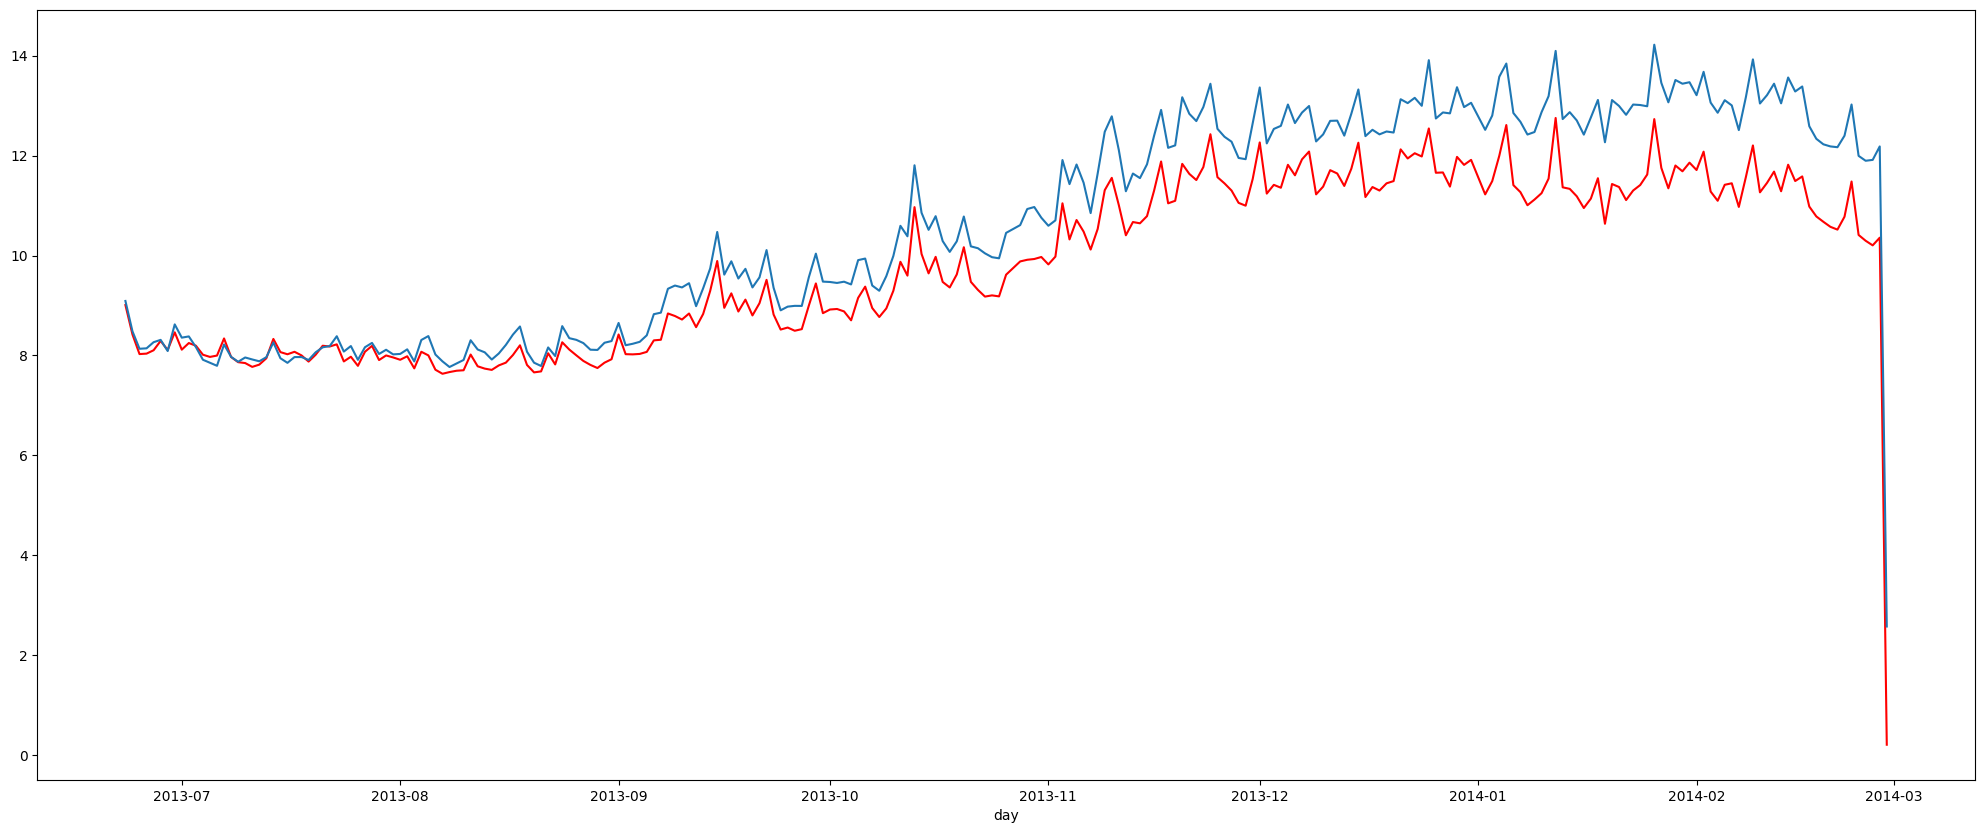

In [75]:
test['avg_energy'].plot(figsize=(25,10),color = 'red')
test['predicted'].plot()
plt.show()

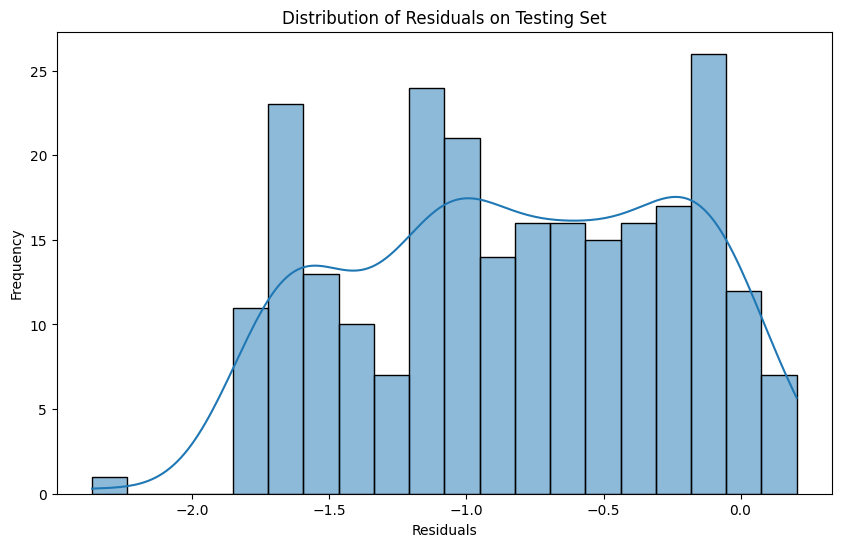

In [76]:
# Calculate residuals for the test set
test_residuals = test['avg_energy'] - test['predicted']

# Plot the distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(test_residuals, bins=20, kde=True)
plt.title('Distribution of Residuals on Testing Set')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


## LSTM2

In [80]:
# Define the columns you want to include
selected_columns = ['energy_sum', 'temperatureMax', 'windBearing', 'dewPoint', 'cloudCover',
                    'windSpeed', 'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
                    'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex', 'temperatureLow',
                    'temperatureMin', 'temperatureHigh', 'apparentTemperatureMin', 'moonPhase',
                    'holiday_ind', 'Year', 'Month', 'avg_energy']  # Include target variable as well

# Filter the columns in the original dataset
weather_energy_filtered = weather_energy[selected_columns]

In [81]:
np.random.seed(11)
dataframe = weather_energy.loc[:,'avg_energy']
dataset = dataframe.values
dataset = dataset.astype('float32')

In [82]:
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Convert the filtered dataset to supervised learning format
reframed = series_to_supervised(weather_energy_filtered.values, 7, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
reframed_scaled = scaler.fit_transform(reframed)

# Split into train and test sets
train = reframed_scaled[:-30, :]
test = reframed_scaled[-30:, :]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train[:, :-1].reshape((train.shape[0], 1, train.shape[1]-1))
train_y = train[:, -1]
test_X = test[:, :-1].reshape((test.shape[0], 1, test.shape[1]-1))
test_y = test[:, -1]

**Modelling**

Epoch 1/100
12/12 - 8s - loss: 0.1395 - val_loss: 0.0355 - 8s/epoch - 651ms/step
Epoch 2/100
12/12 - 0s - loss: 0.0249 - val_loss: 0.0268 - 184ms/epoch - 15ms/step
Epoch 3/100
12/12 - 0s - loss: 0.0060 - val_loss: 0.0163 - 180ms/epoch - 15ms/step
Epoch 4/100
12/12 - 0s - loss: 0.0059 - val_loss: 0.0211 - 105ms/epoch - 9ms/step
Epoch 5/100
12/12 - 0s - loss: 0.0035 - val_loss: 0.0179 - 114ms/epoch - 10ms/step
Epoch 6/100
12/12 - 0s - loss: 0.0030 - val_loss: 0.0165 - 129ms/epoch - 11ms/step
Epoch 7/100
12/12 - 0s - loss: 0.0028 - val_loss: 0.0168 - 102ms/epoch - 9ms/step
Epoch 8/100
Restoring model weights from the end of the best epoch: 3.
12/12 - 0s - loss: 0.0025 - val_loss: 0.0166 - 107ms/epoch - 9ms/step
Epoch 8: early stopping


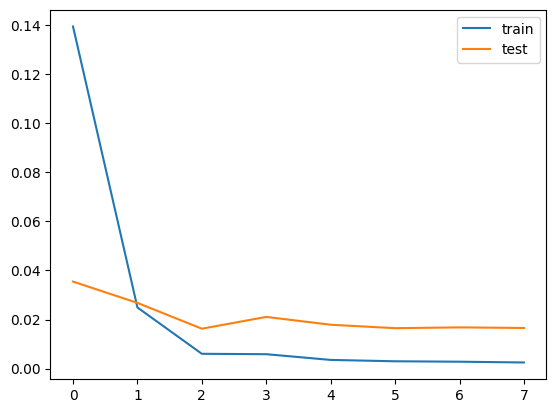

In [202]:
# Define the LSTM model with the best hyperparameters
model = Sequential()
model.add(LSTM(100, activation='tanh', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model with early stoppin
history = model.fit(train_X, train_y, epochs=100, batch_size=70,
                    validation_data=(test_X, test_y), verbose=2,
                    shuffle=False, callbacks=[early_stopping])

# Plot training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [170]:
print(tf.__file__)

/usr/local/lib/python3.10/dist-packages/tensorflow/__init__.py


**Prediction**

1/1 [==============================] - 0s 422ms/step
Test RMSE: 10525.998


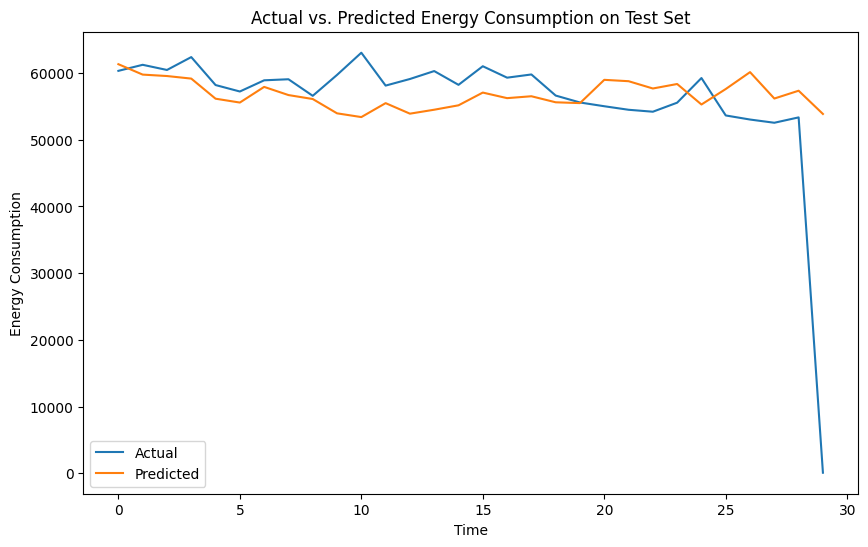

In [203]:
# Make predictions on the test set
yhat = model.predict(test_X)

# Reshape test_X to have the appropriate shape
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Invert scaling for forecasted values
inv_yhat_concat = np.concatenate((yhat, test_X_reshaped), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat_concat)
predicted_values = inv_yhat[:, 0]

# Invert scaling for actual values
test_y = test_y.reshape((-1, 1))  # Reshape test_y to have one column
inv_y_concat = np.concatenate((test_y, test_X_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y_concat)
actual_values = inv_y[:, 0]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print('Test RMSE: %.3f' % rmse)

# Visualize actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual')
plt.plot(predicted_values, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.title('Actual vs. Predicted Energy Consumption on Test Set')
plt.legend()
plt.show()